# Main Plotting of liftetime withdrawal for different sectors

In [1]:
import os
import xarray as xr
import pickle as pk
import time
import matplotlib as mpl
import matplotlib.colors as mpl_colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from settings import *
from load_manip import *
from exposure import * 
from utils import *
from main_function import *

# Script to plot countries
from plotting import *

# set own plotting parameters
set_plot_param()
map_proj = ccrs.Robinson(central_longitude=0, globe=None)

%matplotlib inline 

In [2]:
# extreme event
global flags

flags = {}


flags['mode'] = 'exposure'   # whether to calculate exposure, duration, intensity or all. 

flags['runs'] = 0           # 0: do not process ISIMIP runs (i.e. load runs pickle)
                            # 1: process ISIMIP runs (i.e. produce and save runs as pickle)
flags['mask'] = 0           # 0: do not process country data (i.e. load masks pickle)
                            # 1: process country data (i.e. produce and save masks as pickle)
flags['exposure'] = 0     # 0: do not process ISIMIP runs to compute exposure (i.e. load exposure pickle)
                            # 1: process ISIMIP runs to compute exposure (i.e. produce and save exposure as pickle)
flags['exposure_pic'] = 0   # 0: do not process ISIMIP runs to compute picontrol exposure (i.e. load exposure pickle)
flags['expectancy'] = 0     # 1: apply option of constant life expectancy


regions = ['East Asia & Pacific', 'Europe & Central Asia', 'Latin America & Caribbean', 'Middle East & North Africa', 'North America', 'South Asia', 'Sub-Saharan Africa']
income_regions = ['Low income', 'High income', 'Lower middle income','Upper middle income']

d_regions = {'world': ['East Asia & Pacific', 'Europe & Central Asia', 'Latin America & Caribbean', 'Middle East & North Africa', 'North America', 'South Asia', 'Sub-Saharan Africa'], 
           'income' :[  'Lower middle income','Low income', 'High income','Upper middle income',]}

d_colors = {'domww' : 'steelblue', 'indww' :'orange','irrww':'olivedrab'}

colors = ['steelblue','orange','olivedrab']

# 1: process ISIMIP runs to compute picontrol exposure (i.e. produce and save exposure as pickle)
# TODO: add rest of flags

### Load and manipulate  files for plotting

In [3]:
# load country borders (from pickles)

d_countries = pd.read_pickle(open('./data/pickles/country_info.pkl', 'rb'))

# unpack country information
gdf_country_borders = d_countries['borders']



/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  setstate(state)
/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  setstate(state)


## Load sectoral withdrawals

In [5]:
#def calc_lifetime_waterdeficit(flags): 
sectors = ['indww','domww','irrww']

d_sectors = {}
d_sectors_perregion = {}
d_sectors_allruns = {}

for sector in sectors:
    print(sector)
    flags['extr'] =  sector # 0: all
    d_sector, d_sector_perregion, d_sector_allruns = do_lifetime_analysis(flags)

    d_sectors_allruns[sector] = d_sector_allruns

    ## find indices of RCP scenarios per simulation

    # unpack info from isimip simulations - to know RCP scenario
    with open('./data/pickles/isimip_metadata_{}_{}.pkl'.format(flags['extr'],'exposure'), 'rb') as f:
        d_isimip_meta = pd.read_pickle(f)

    ind_rcp26 = []
    ind_rcp60 = []
    for i in d_isimip_meta.keys(): 
        if   d_isimip_meta[i]['rcp'] == 'rcp26':
            ind_rcp26.append(i)
        elif d_isimip_meta[i]['rcp'] == 'rcp60':
            ind_rcp60.append(i)

    # filter simulations based on RCP scenario
    d_sector_rcp26runs = {i: d_sector_allruns['exposure_perrun_RCP'][i] for i in ind_rcp26}
    d_sector_rcp60runs = {i: d_sector_allruns['exposure_perrun_RCP'][i] for i in ind_rcp60}

    # per country

    d_sector_RCP26 = calc_exposure_mmm_xr(d_sector_rcp26runs, 'country', 'RCP26' )
    d_sector_RCP60 = calc_exposure_mmm_xr(d_sector_rcp60runs, 'country', 'RCP60' )

    # pool all datasets for different trajectories
    d_sectors[sector] = xr.merge([d_sector_RCP26,  d_sector_RCP60])

    # per region (calculating based on country withdrawal and deficit vs averaging country % water deficits directly)
    # (This is alternative to what is done in the main function: calculating the waterdeficit and withdrawal per region based on countries and only then taking the ratio)
    d_sector_perregion_perrun_RCP26_all = calc_pctwaterdeficit_perregion_perrun(d_sector_rcp26runs)
    d_sector_perregion_perrun_RCP60_all = calc_pctwaterdeficit_perregion_perrun(d_sector_rcp60runs)

    
    # calculate multi-model statistics
    d_sector_perregion_perrun_RCP26 = calc_exposure_mmm_xr(d_sector_perregion_perrun_RCP26_all, 'region', 'RCP26' )
    d_sector_perregion_perrun_RCP60 = calc_exposure_mmm_xr(d_sector_perregion_perrun_RCP60_all, 'region', 'RCP60' )

    d_sectors_perregion[sector] = xr.merge([ d_sector_perregion_perrun_RCP26,  d_sector_perregion_perrun_RCP60])

    #return ds_pct_waterdeficit, ds_pct_waterdeficit_perregion, d_pct_waterdeficit_perrun_RCP26, d_pct_waterdeficit_perrun_RCP60


# convert dicts into datasets    
ds_sectors = xr.concat([d_sectors[sector] for sector in d_sectors.keys()], dim='sector')
ds_sectors['sector']= list(d_sectors.keys())

ds_sectors_perregion = xr.concat([d_sectors_perregion[sector] for sector in d_sectors_perregion.keys()], dim='sector')
ds_sectors_perregion['sector']= list(d_sectors_perregion.keys())

indww
Loading processed country and region data


/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  setstate(state)
/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  setstate(state)


Loading processed isimip data
Loading processed exposures


/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  setstate(state)
/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  setstate(state)
/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  setstate(state)
/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be re

domww
Loading processed country and region data


/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  setstate(state)
/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  setstate(state)


Loading processed isimip data
Loading processed exposures


/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  setstate(state)
/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  setstate(state)
/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  setstate(state)
/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be re

irrww
Loading processed country and region data


/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  setstate(state)
/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  setstate(state)


Loading processed isimip data
Loading processed exposures


/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  setstate(state)
/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  setstate(state)
/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  setstate(state)
/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be re

In [7]:
totww = d_sectors['indww'] + d_sectors['irrww'] + d_sectors['domww']
totww_perregion = d_sectors_perregion['indww'] + d_sectors_perregion['irrww'] + d_sectors_perregion['domww']

indww_rel = d_sectors['indww'] / totww *100
domww_rel = d_sectors['domww'] / totww *100
irrww_rel = d_sectors['irrww'] / totww *100

indww_perregion_rel = d_sectors_perregion['indww'] / totww_perregion *100
domww_perregion_rel = d_sectors_perregion['domww'] / totww_perregion *100
irrww_perregion_rel = d_sectors_perregion['irrww'] / totww_perregion *100

## Plotting

/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


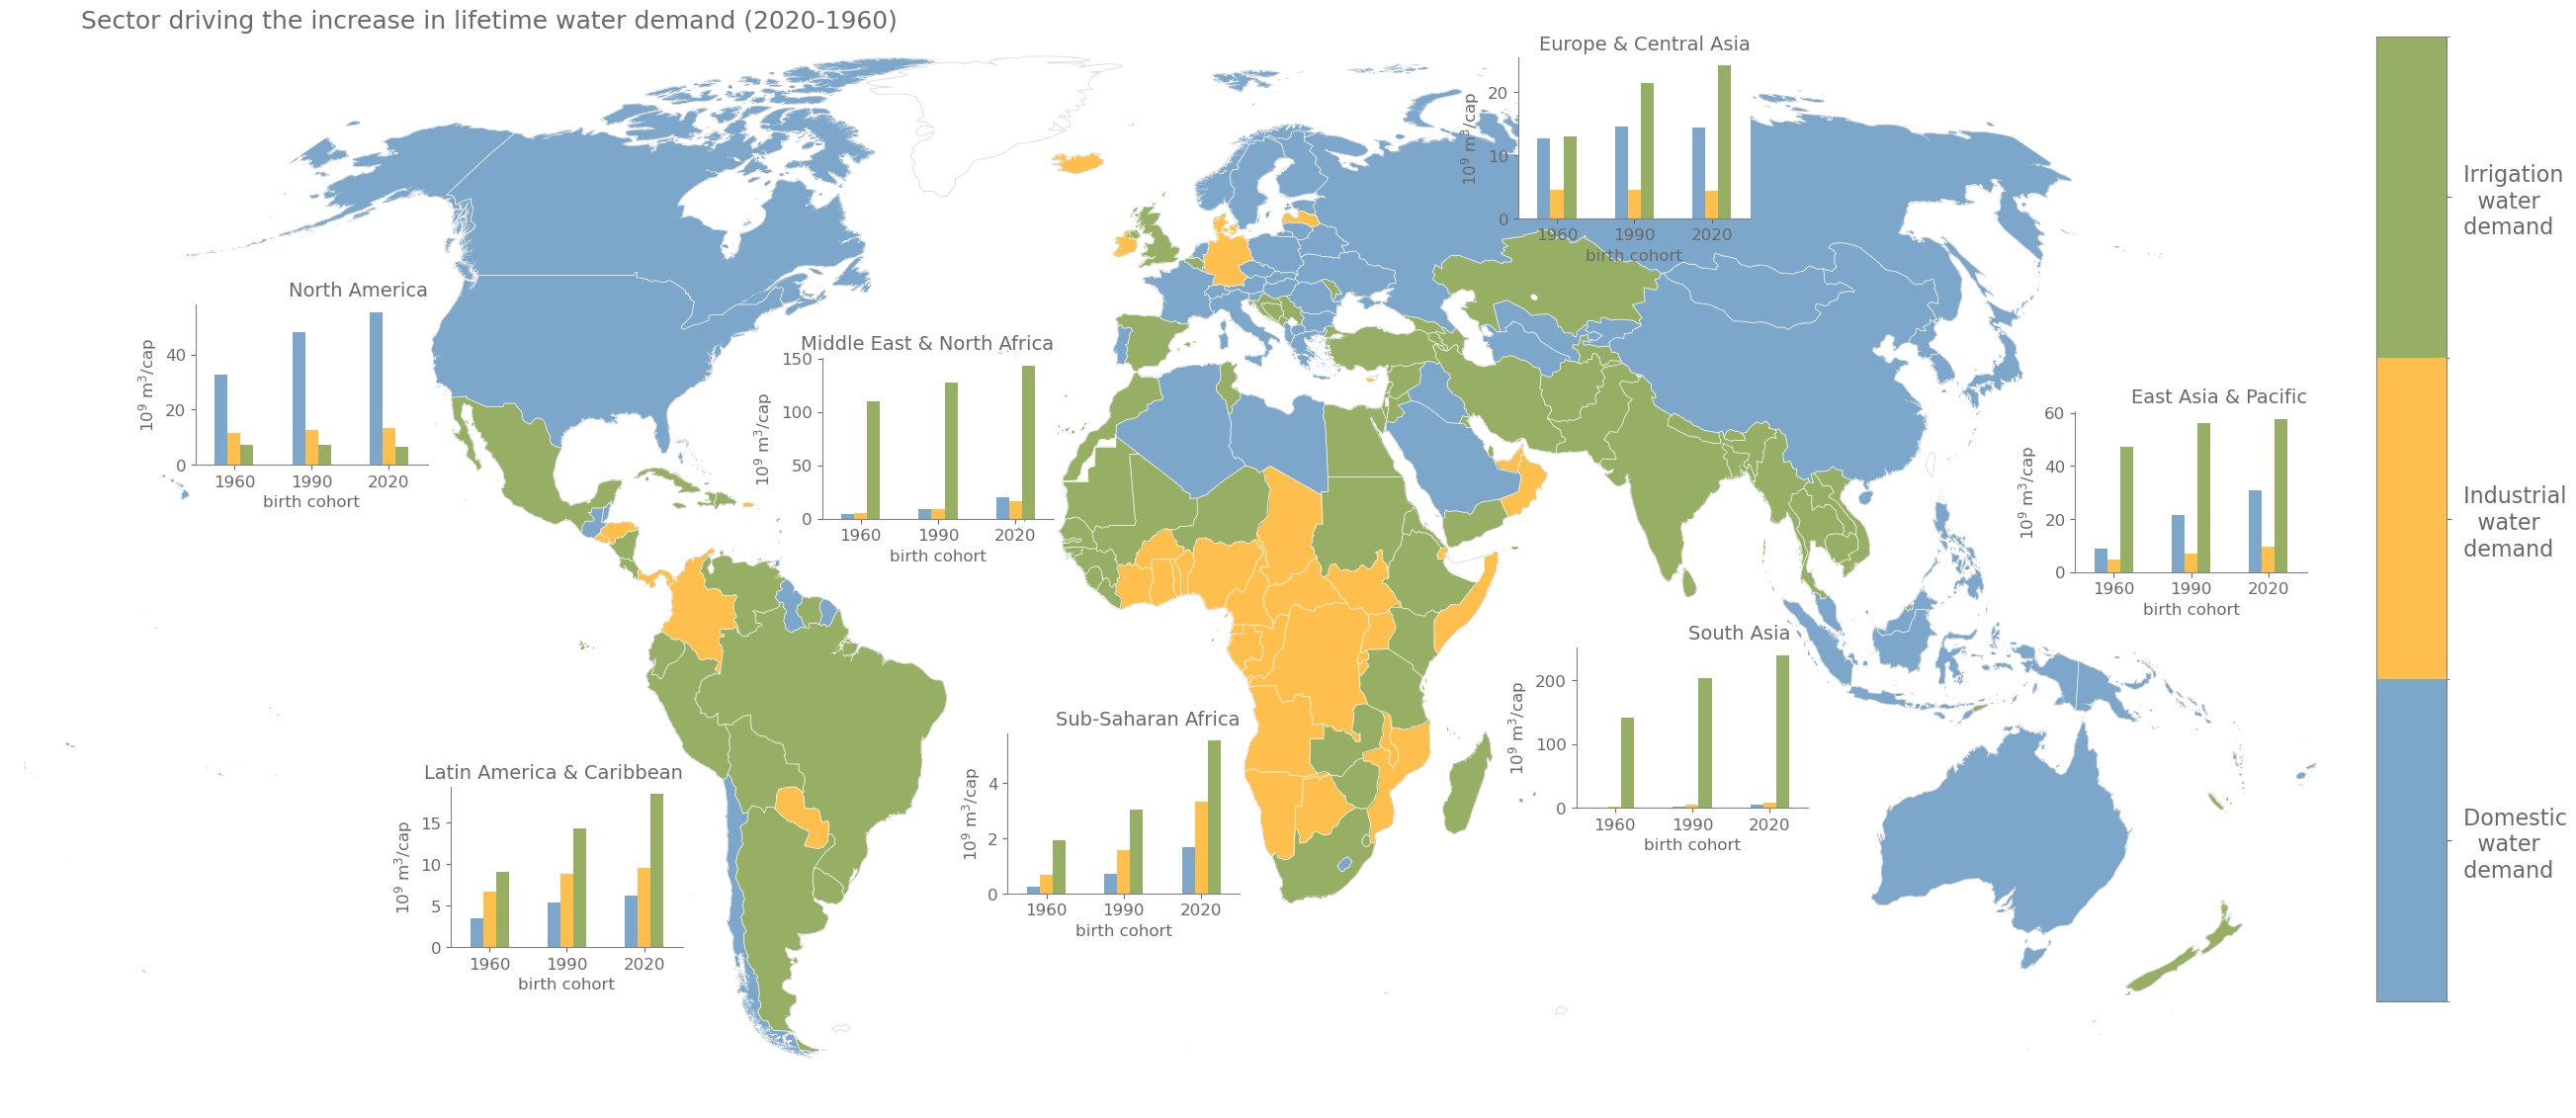

In [8]:
var = 'mmm_RCP60'
# get delta of all sectors
ds_sectors_delta = ds_sectors.sel(birth_year=2020) - ds_sectors.sel(birth_year=1960)

# get sectors with maximum absolute difference 
da_sector_maxdelta = ds_sectors_delta[var].argmax(dim='sector')

# select birth years and merge with gpd countries
bounds = np.array([0,1,2,3])

cmap = mpl_colors.ListedColormap(colors, name='sectors')
legend_label = ""
df = da_sector_maxdelta.to_dataframe()

gdf_exposure_birthyear = gdf_country_borders.merge(df, left_index=True, right_on='country')

fig, ax = plt.subplots(figsize=(26,14), subplot_kw={'projection':map_proj})
ax.axis('off')
cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)
gdf_exposure_birthyear.plot(ax=ax, column=var, cax=cax, legend = True,  cmap= cmap, legend_kwds={'label': legend_label, 'ticks':[0.5,1.5,2.5], 'alpha' : 0.7}, transform=ccrs.PlateCarree(), norm = mpl_colors.BoundaryNorm(boundaries=bounds, ncolors=3), alpha=0.7)
ax.set_title('         Sector driving the increase in lifetime water demand (2020-1960)', loc='left', size=18); 
cax.set_yticklabels([' Domestic\n   water\n demand',' Industrial\n   water\n demand',' Irrigation\n   water\n demand']);
cax.tick_params(labelsize=16)

# inset axis
ax_loc = {}
ax_loc['Latin America & Caribbean'] = [0.19, 0.15, 0.1, 0.15] # latin america
ax_loc['North America'] = [0.08, 0.6, 0.1, 0.15] # North America
ax_loc['Europe & Central Asia'] = [0.65, 0.83, 0.1, 0.15] # Europe and central asia
ax_loc['Middle East & North Africa'] = [0.35, 0.55, 0.1, 0.15] # Middle East and north Africa
ax_loc['Sub-Saharan Africa'] = [0.43, 0.2, 0.1, 0.15] # Subsaharan AfricA
ax_loc['South Asia'] = [0.675, 0.28, 0.1, 0.15] #sOUTH aSIA
ax_loc['East Asia & Pacific'] = [0.89, 0.50, 0.1, 0.15] # East Asia Pacific


ds_sectors_perregion = xr.concat([d_sectors_perregion[sector] for sector in d_sectors_perregion.keys()], dim='sector')
ds_sectors_perregion['sector']= list(d_sectors_perregion.keys())

ds_sectors_sel = ds_sectors_perregion['mmm_RCP60'].where(ds_sectors_perregion['birth_year'].isin([1960,1990,2020]), drop=True)
total_deficit_sumsectors = ds_sectors_perregion.sum('sector')['mmm_RCP60'].where(ds_sectors_perregion['birth_year'].isin([1960,1990,2020]), drop=True)

for i, region in enumerate(regions):

    ax_inset=ax.inset_axes(ax_loc[region]) #[x0, y0, width, height]
    ax_inset.grid(color='lightgray', alpha=0.5)

    ds_sectors_region = ds_sectors_sel.sel(region=region)
    df_sectors= pd.DataFrame(ds_sectors_region.values.T, index=  ds_sectors_region.birth_year ,columns =ds_sectors_region.sector) * 1e-9

    df_sectors.plot.bar(ax=ax_inset, color=colors, rot=0, alpha=0.7, legend=False)
    if region == 'South Asia': 
        region = 'South Asia   '
    ax_inset.set_title(region, loc='right', fontsize=14)
    #ax.set_ylim([0,100])
    ax_inset.spines[['right', 'top']].set_visible(False)
    ax_inset.set_ylabel('10$^9$ m$^3$/cap', fontsize=12)
    ax_inset.set_xlabel('birth cohort', fontsize=12)

   # if region=='North America': 
   #     ax_inset.legend(['Domestic', 'Industrial','Irrigation'], frameon=False) # bbox_to_anchor=(1.3,1),loc='center',
        
fig.tight_layout()
plt.savefig('figures/sectoral.png', bbox_inches='tight',dpi=600)


## Values

Across South Asia, as well as in the majority of Latin America and parts of Africa, irrigation demand is also the main driving sector behind generational differences and accounts for XX-YY\% of the overall change. In most countries of the Global North, however, the generational difference in lifetime water demand is mainly driven by rising domestic water demand (typically accounting for XX-YY\% of the overall change). 

In [7]:
region_to_select = ['Latin America & Caribbean', 'Sub-Saharan Africa', 'South Asia']
all_irrigation_shares = []

for region in region_to_select:

    ds_sectors_region = ds_sectors_sel.sel(region=region)
    irrigation_share = ((ds_sectors_region.sel(sector='irrww')/ds_sectors_region.sum('sector'))*100).values
    all_irrigation_shares.append(irrigation_share)

print(f"Irrigation share range: {np.min(np.asarray(all_irrigation_shares)):.1f} - {np.max(np.asarray(all_irrigation_shares)):.1f} %")



region_to_select = ['North America',  'Europe & Central Asia']
all_domestic_shares = []

for region in region_to_select:

    ds_sectors_region = ds_sectors_sel.sel(region=region)
    domestic_share = ((ds_sectors_region.sel(sector='domww')/ds_sectors_region.sum('sector'))*100).values
    all_domestic_shares.append(domestic_share)

print(f"Domestic share range: {np.min(np.asarray(all_domestic_shares)):.1f} - {np.max(np.asarray(all_domestic_shares)):.1f} %")


Irrigation share range: 47.5 - 97.2 %
Domestic share range: 10.1 - 22.3 %


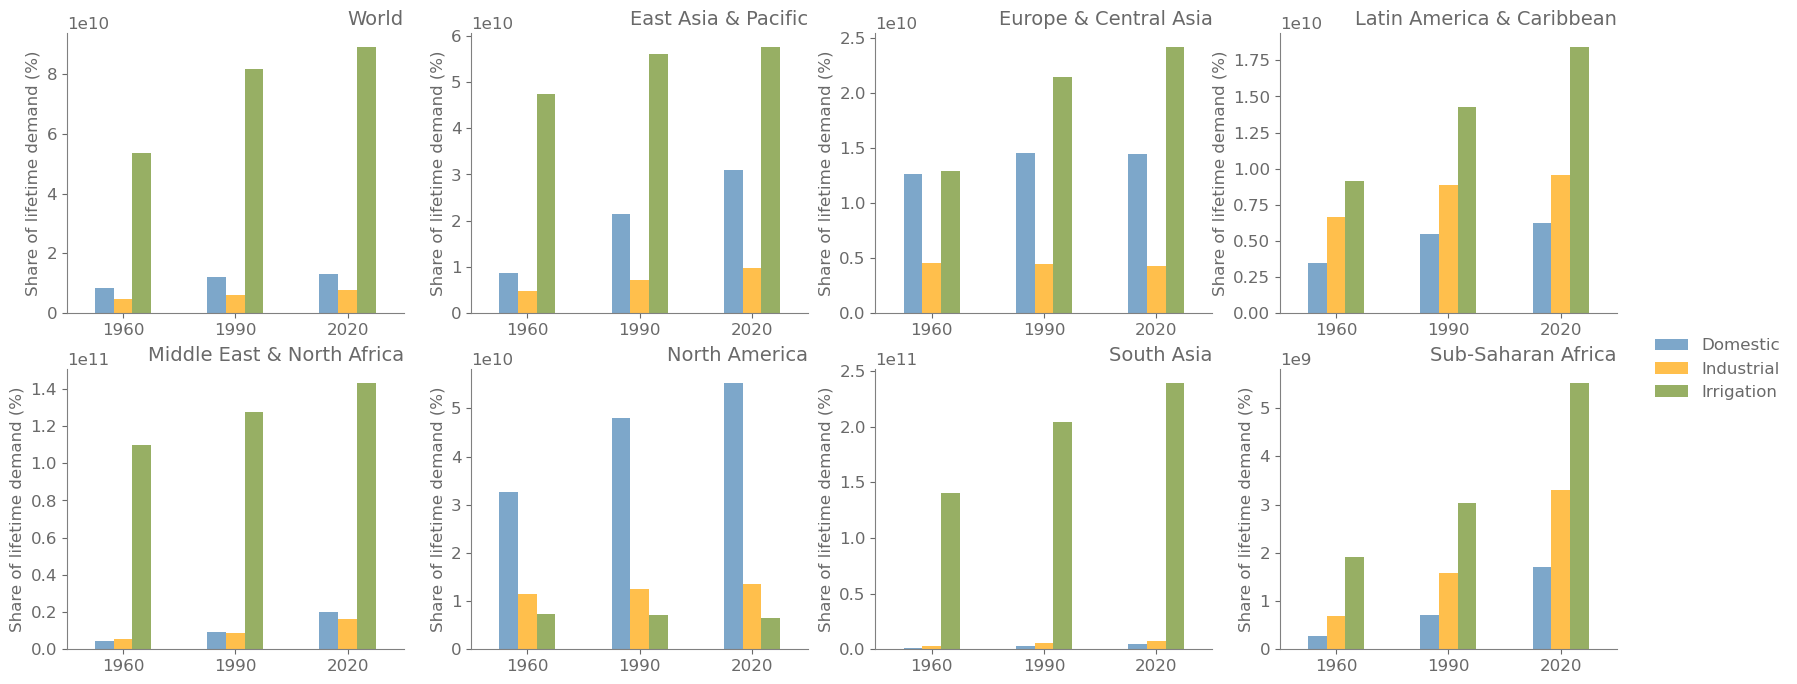

In [6]:
# ADD IN INDWW

fig, axes = plt.subplots(2,4, figsize=(20, 8));
axes = axes.flatten()

regions_toplot = ['World'] + regions
#axes[-1].axis('off')

ds_sectors_perregion = xr.concat([d_sectors_perregion[sector] for sector in d_sectors_perregion.keys()], dim='sector')
ds_sectors_perregion['sector']= list(d_sectors_perregion.keys())


ds_sectors_sel = ds_sectors_perregion['mmm_RCP60'].where(ds_sectors_perregion['birth_year'].isin([1960,1990,2020]), drop=True)
total_deficit_sumsectors = ds_sectors_perregion.sum('sector')['mmm_RCP60'].where(ds_sectors_perregion['birth_year'].isin([1960,1990,2020]), drop=True)

for i, region in enumerate(regions_toplot):
    ax = axes[i] 
    ax.grid(color='lightgray', alpha=0.5)

    ds_sectors_region = ds_sectors_sel.sel(region=region)
    df_sectors= pd.DataFrame(ds_sectors_region.values.T, index=  ds_sectors_region.birth_year ,columns =ds_sectors_region.sector)

    df_sectors.plot.bar(ax=ax, color=colors, rot=0, alpha=0.7, legend=False)
    ax.set_title(region, loc='right')
    #ax.set_ylim([0,100])
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylabel('Share of lifetime demand (%)')

    if i == len(regions_toplot)-1: 
        ax.legend(['Domestic', 'Industrial', 'Irrigation'],bbox_to_anchor=(1.3,1),loc='center', frameon=False)


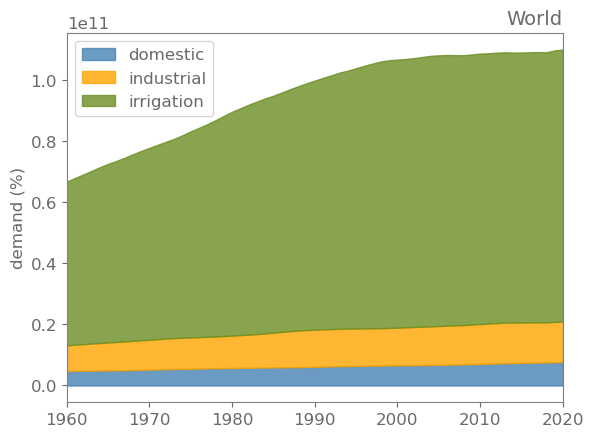

In [9]:
country = 'World'

under = d_sectors_perregion['domww'][var].sel(region=country) 
middle = under + d_sectors_perregion['indww'][var].sel(region=country)
upper = middle + d_sectors_perregion['irrww'][var].sel(region=country)

fig,ax = plt.subplots()

ax.fill_between(under['birth_year'].values, 0, under, label='domestic', color='steelblue', alpha=0.8)
ax.fill_between(under['birth_year'].values, under,middle, label='industrial',color='orange', alpha=0.8)
ax.fill_between(under['birth_year'].values, middle, upper, label='irrigation',color='olivedrab', alpha=0.8)
ax.set_xlim([1960,2020])

ax.set_ylabel('demand (%)')
ax.set_title(' ')
ax.set_title(country, loc='right');
ax.legend();



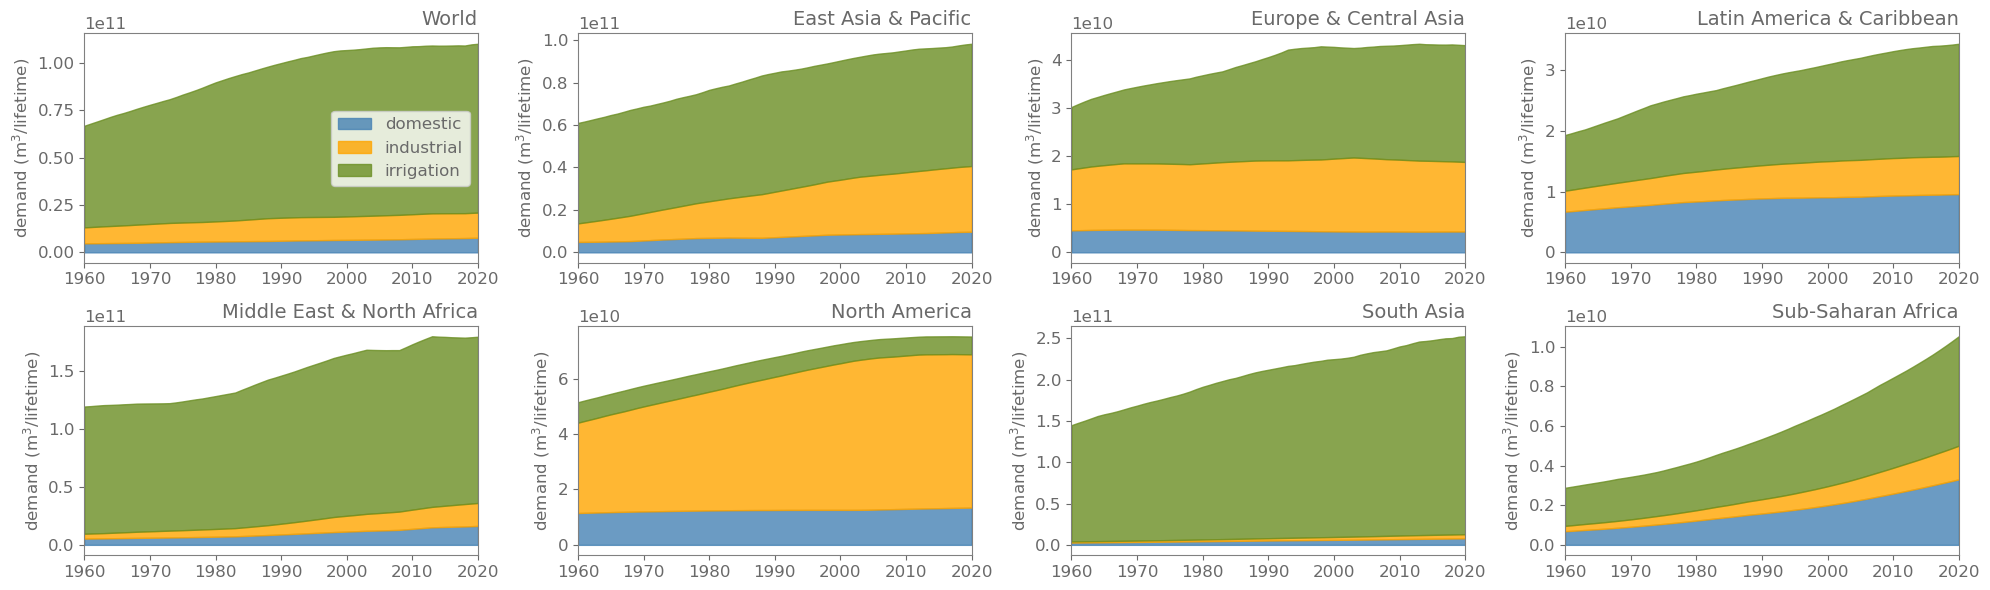

In [10]:
fig, axes = plt.subplots(2,4, figsize=(20,6))
axes = axes.flatten()

var = 'mmm_RCP60'

regions_toplot = ['World'] + regions

for i,region in enumerate(regions_toplot): 
    
    
    
    ax = axes[i]
    under = d_sectors_perregion['domww'][var].sel(region=region) 
    middle = under + d_sectors_perregion['indww'][var].sel(region=region)
    upper = middle + d_sectors_perregion['irrww'][var].sel(region=region)


    ax.fill_between(under['birth_year'].values, 0, under, label='domestic', color='steelblue', alpha=0.8)
    ax.fill_between(under['birth_year'].values, under,middle, label='industrial',color='orange', alpha=0.8)
    ax.fill_between(under['birth_year'].values, middle, upper, label='irrigation',color='olivedrab', alpha=0.8)
    ax.set_xlim([1960,2020])

    ax.set_ylabel('demand (m$^3$/lifetime)')
    ax.set_title(' ')
    ax.set_title(region, loc='right');
    if i == 0:
        ax.legend();
fig.tight_layout()


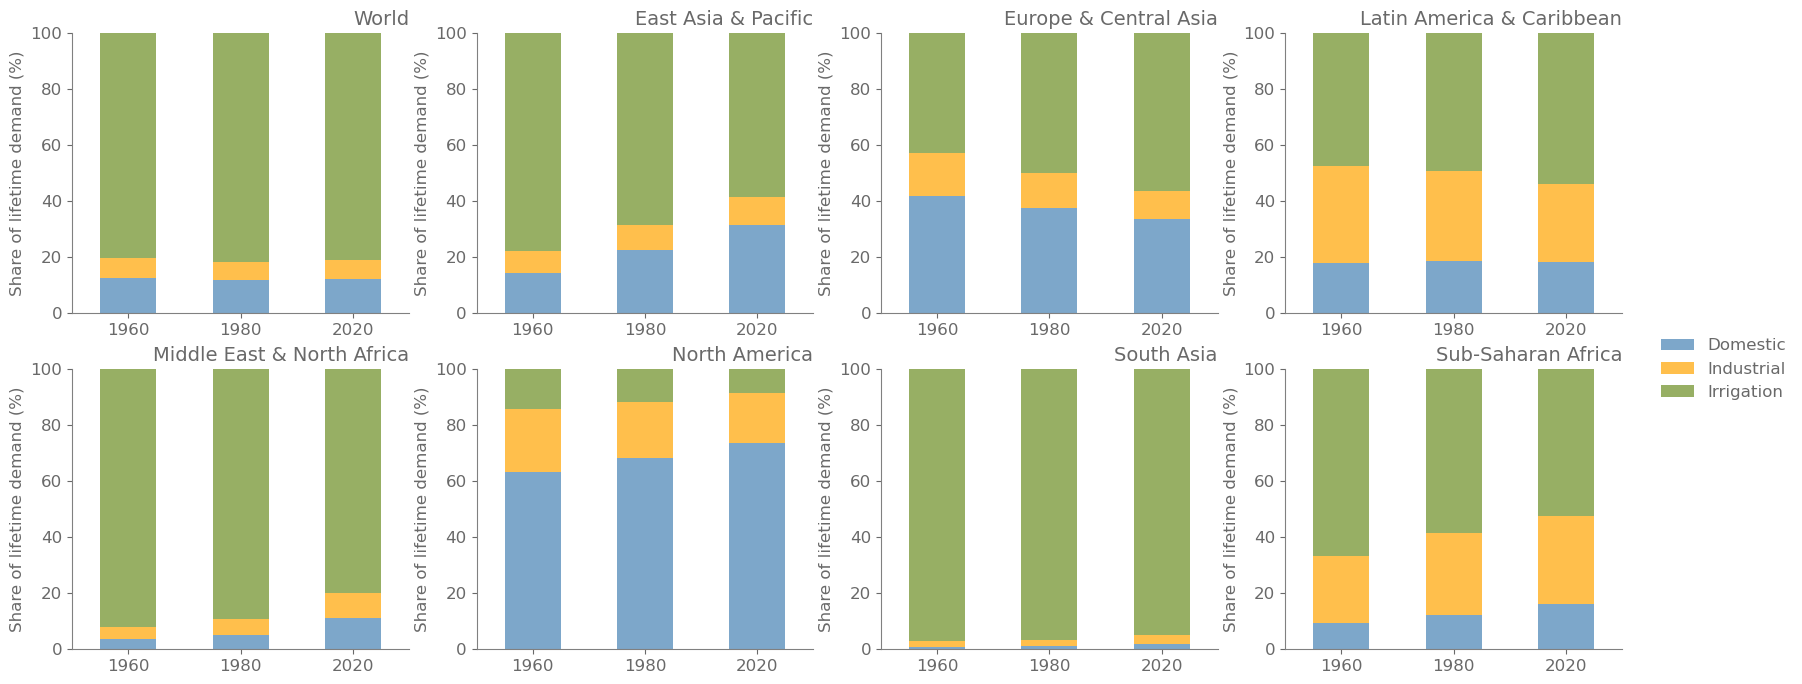

In [ ]:
# ADD IN INDWW

fig, axes = plt.subplots(2,4, figsize=(20, 8));
axes = axes.flatten()

regions_toplot = ['World'] + regions
#axes[-1].axis('off')

ds_sectors_perregion = xr.concat([d_sectors_perregion[sector] for sector in d_sectors_perregion.keys()], dim='sector')
ds_sectors_perregion['sector']= list(d_sectors_perregion.keys())


ds_sectors_sel = ds_sectors_perregion['mmm_RCP60'].where(ds_sectors_perregion['birth_year'].isin([1960,1990,2020]), drop=True)
total_deficit_sumsectors = ds_sectors_perregion.sum('sector')['mmm_RCP60'].where(ds_sectors_perregion['birth_year'].isin([1960,1990,2020]), drop=True)

for i, region in enumerate(regions_toplot):
    ax = axes[i] 
    ax.grid(color='lightgray', alpha=0.5)

    ds_sectors_region = (ds_sectors_sel.sel(region=region) / total_deficit_sumsectors.sel(region=region))*100
    df_sectors= pd.DataFrame(ds_sectors_region.values.T, index=  ds_sectors_region.birth_year ,columns =ds_sectors_region.sector)

    df_sectors.plot.bar(ax=ax, color=colors,stacked=True, rot=0, alpha=0.7, legend=False)
    ax.set_title(region, loc='right')
    ax.set_ylim([0,100])
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylabel('Share of lifetime demand (%)')

    if i == len(regions_toplot)-1: 
        ax.legend(['Domestic', 'Industrial','Irrigation'],bbox_to_anchor=(1.3,1),loc='center', frameon=False)
